## Initialization code

In [299]:
#\snippet{init-installs}{Additional libraries installation}
!pip install plotly==4.12.0
!pip install statsmodels==0.12.2
!pip install pymc3==3.11.4
!pip install kaleido==0.2.1
!pip install arviz==0.11.4

In [300]:
#\snippet{init-imports}{Libraries import}
from __future__ import annotations
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import requests
import plotly
import plotly.graph_objects as go
import plotly.express as px
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib
from dataclasses import dataclass, field
from pymc3.gp.util import plot_gp_dist
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
from collections import defaultdict
from typing import List
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.graphics.gofplots import qqplot

## Config

In [296]:
#\snippet{config}{Top level configuration of this notebook}
# set this to `False` once the thesis is done
# (we do not need to generate output afterwards)
GENERATE_OUTPUT_FILES = True

## Utilities

In [4]:
#\snippet{utils-base-figure}{Base abstract figure class for plotting}
class BaseFigure(ABC):
    @abstractmethod
    def show(self) -> BaseFigure:
        pass

    @abstractmethod
    def save(self, image_name: str) -> BaseFigure:
        pass

    @staticmethod
    def _make_filename(image_name):
        return "generated/images/{}.png".format(image_name)

In [5]:
#\snippet{utils-base-plotly}{Plotly figure base class}
class PlotlyFigure(BaseFigure):
    def __init__(self, figure, width=800, height=400):
        assert isinstance(figure, go.Figure)
        figure.update_layout(margin=dict(l=0, r=0, b=0, t=30), width=width, height=height)
        self._figure = figure

    def show(self) -> BaseFigure:
        self._figure.show()
        return self

    def save(self, image_name: str) -> BaseFigure:
        if GENERATE_OUTPUT_FILES:
            self._figure.write_image(self._make_filename(image_name), engine="kaleido", scale=1.2)

        return self

In [6]:
#\snippet{utils-base-matplotlib}{MatPlotLib figure base class}
class MatPlotLibFigure(BaseFigure):
    def __init__(self, figure):
        assert isinstance(figure, matplotlib.figure.Figure)
        self._figure = figure

    def show(self) -> BaseFigure:
        plt.show(self._figure)

        return self

    def save(self, image_name) -> BaseFigure:
        if GENERATE_OUTPUT_FILES:
            self._figure.savefig(self._make_filename(image_name), bbox_inches='tight')

        return self

In [235]:
#\snippet{utils-base-latex}{Base class for LaTeX tables generation}
class LaTeXTable:
    def __init__(self, table_name, caption, columns: List[str], no_header = False):
        self._table_name = table_name
        self._caption = caption
        self._columns = columns
        self._no_header = no_header
        self._rows = []
        self._code = None

    def add_row(self, entry: List[str]):
        assert len(entry) == len(self._columns)

        self._rows.append(entry)

    @property
    def code(self) -> str:
        if self._code is None:
            self._code = r"\begin{table}[H]" + "\n"
            self._code += r"\begin{tabularx}{\textwidth}{" + \
                "".join(["X" for _ in self._columns]) + "}" + "\n"
            self._code += r"\toprule" + "\n"

            if not self._no_header:
                self._code += " & ".join(self._columns) + r" \\" + "\n"

            self._code += r"\midrule" + "\n"
            
            for row in self._rows:
                self._code += " & ".join(row) + r" \\" + "\n"

            self._code += r"\bottomrule" + "\n"
            self._code += r"\end{tabularx}" + "\n"

            self._code += r"\caption{" + self._caption + r"}" + "\n"
            self._code += r"\label{tab:" + self._table_name + r"}" + "\n"
            self._code += r"\end{table}" + "\n"

        return self._code

    def show(self) -> LatexTable:
        print(self.code)

        return self

    def save(self) -> LatexTable:
        if GENERATE_OUTPUT_FILES:
            with open("generated/tables/{}.tex".format(self._table_name),"w+") as fp:
                fp.write(self.code)

        return self

In [74]:
#\snippet{utils-data-node}{A data node - basic data carrier for each locality}
def convert_to_date(value):
    return dt.datetime.strptime(value, '%Y-%m-%d').date()

@dataclass
class DataNodeMeasurements:
    index: np.ndarray
    Y_C0: int
    Y_R0: int
    Y_D0: int
    Y_C: np.ndarray
    Y_R: np.ndarray
    Y_D: np.ndarray
    Y_dC: np.ndarray
    Y_dR: np.ndarray
    Y_dD: np.ndarray

@dataclass
class DataNode:
    nuts: str
    name: str
    N: int
    measurements: DataNodeMeasurements = field(default=None)

In [75]:
#\snippet{utils-cz-root}{Instantiating static data}
def make_data_nodes_dict(nodes):
    result = {}

    for node in nodes:
        result[node.nuts] = node

    return result

# N taken from https://www.czso.cz/documents/10180/142756350/1300722101.pdf/5957c9a9-24b5-4b96-ba77-2fa7a5bfb1b5?version=1.1
data_nodes = make_data_nodes_dict([
    # "Hlavní město Praha"
    DataNode("CZ0100", "Praha", 1335084),

    # "Středočeský kraj"
    DataNode("CZ0201", "Benešov", 99742),
    DataNode("CZ0202", "Beroun", 96403),
    DataNode("CZ0203", "Kladno", 166845),
    DataNode("CZ0204", "Kolín", 103932),
    DataNode("CZ0205", "Kutná Hora", 76310),
    DataNode("CZ0206", "Mělník", 109987),
    DataNode("CZ0207", "Mladá Boleslav", 131042),
    DataNode("CZ0208", "Nymburk", 101539),
    DataNode("CZ0209", "Praha-východ", 188939),
    DataNode("CZ020A", "Praha-západ", 152285),
    DataNode("CZ020B", "Příbram", 115236),
    DataNode("CZ020C", "Rakovník", 55737),

    # "Jihočeský kraj"
    DataNode("CZ0311", "České Budějovice", 196602),
    DataNode("CZ0312", "Český Krumlov", 61320),
    DataNode("CZ0313", "Jindřichův Hradec", 90279),
    DataNode("CZ0314", "Písek", 71588),
    DataNode("CZ0315", "Prachatice", 50779),
    DataNode("CZ0316", "Strakonice", 70532),
    DataNode("CZ0317", "Tábor", 102451),

    # "Plzeňský kraj"
    DataNode("CZ0321", "Domažlice", 55268),
    DataNode("CZ0322", "Klatovy", 86253),
    DataNode("CZ0323", "Plzeň-město", 194840),
    DataNode("CZ0324", "Plzeň-jih", 70131),
    DataNode("CZ0325", "Plzeň-sever", 80671),
    DataNode("CZ0326", "Rokycany", 49489),
    DataNode("CZ0327", "Tachov", 54389),

    # "Karlovarský kraj"
    DataNode("CZ0411", "Cheb", 91434),
    DataNode("CZ0412", "Karlovy Vary", 114374),
    DataNode("CZ0413", "Sokolov", 87503),

    # "Ústecký kraj"
    DataNode("CZ0421", "Děčín", 128449),
    DataNode("CZ0422", "Chomutov", 124600),
    DataNode("CZ0423", "Litoměřice", 119177),
    DataNode("CZ0424", "Louny", 86364),
    DataNode("CZ0425", "Most", 110933),
    DataNode("CZ0426", "Teplice", 128830),
    DataNode("CZ0427", "Ústí nad Labem", 118651),

    # "Liberecký kraj"
    DataNode("CZ0511", "Česká Lípa", 102998),
    DataNode("CZ0512", "Jablonec nad Nisou", 91533),
    DataNode("CZ0513", "Liberec", 175465),
    DataNode("CZ0514", "Semily", 72480),

    # "Královéhradecký kraj"
    DataNode("CZ0521", "Hradec Králové", 164435),
    DataNode("CZ0522", "Jičín", 80134),
    DataNode("CZ0523", "Náchod", 109487),
    DataNode("CZ0524", "Rychnov nad Kněžnou", 79333),
    DataNode("CZ0525", "Trutnov", 117414),

    # "Pardubický kraj"
    DataNode("CZ0531", "Chrudim", 104708),
    DataNode("CZ0532", "Pardubice", 176137),
    DataNode("CZ0533", "Svitavy", 104000),
    DataNode("CZ0534", "Ústí nad Orlicí", 138011),

    # "Kraj Vysočina"
    DataNode("CZ0631", "Havlíčkův Brod", 94612),
    DataNode("CZ0632", "Jihlava", 113664),
    DataNode("CZ0633", "Pelhřimov", 72298),
    DataNode("CZ0634", "Třebíč",  110337),
    DataNode("CZ0635", "Žďár nad Sázavou", 117941),

    # "Jihomoravský kraj"
    DataNode("CZ0641", "Blansko", 109104),
    DataNode("CZ0642", "Brno-město", 382405),
    DataNode("CZ0643", "Brno-venkov", 226442),
    DataNode("CZ0644", "Břeclav", 116482),
    DataNode("CZ0645", "Hodonín", 153607),
    DataNode("CZ0646", "Vyškov", 92735),
    DataNode("CZ0647", "Znojmo", 114552),

    # "Olomoucký kraj"
    DataNode("CZ0711", "Jeseník", 37709),
    DataNode("CZ0712", "Olomouc", 235441),
    DataNode("CZ0713", "Prostějov", 108504),
    DataNode("CZ0714", "Přerov", 128901),
    DataNode("CZ0715", "Šumperk", 119967),

    # "Zlínský kraj"
    DataNode("CZ0721", "Kroměříž", 104826),
    DataNode("CZ0722", "Uherské Hradiště", 141630),
    DataNode("CZ0723", "Vsetín", 141896),
    DataNode("CZ0724", "Zlín", 191767),
    
    # "Moravskoslezský kraj"
    DataNode("CZ0801", "Bruntál", 90971),
    DataNode("CZ0802", "Frýdek-Místek", 214587),
    DataNode("CZ0803", "Karviná", 242779),
    DataNode("CZ0804", "Nový Jičín", 151398),
    DataNode("CZ0805", "Opava", 175777),
    DataNode("CZ0806", "Ostrava-město", 317322)
])

In [76]:
#\snippet-ignore
len(data_nodes)

77

In [236]:
#\snippet{utils-adf-test}{ADF test function (writes to Latex table)}
def adf_test(data, table_name, caption):
    table = LaTeXTable(
        table_name=table_name,
        caption=caption,
        columns=["", "", ""],
        no_header=True)
    result = adfuller(data)

    table.add_row(["ADF Statistic", "", "%.3f" % result[0]])
    table.add_row(["p-value", "", "%.3f" % result[1]])
    table.add_row(["Critical Values", "", ""])

    for key, value in result[4].items():
        table.add_row(["", key.replace("%", "\%"), '%.3f' % value])

    return table

## Data wrangling

In [344]:
#\snippet{data-serial-interval-base}{Base class for serial interval}
class SerialInterval:
    def __init__(self, dist, name):
        self._dist = dist
        self._name = name

    def get_trace(self):
        xx = np.linspace(0, 20, 1000)
        return go.Scatter(x=xx, y=self._dist.pdf(xx), name=self._name)
    
    @property
    def expected_value(self):
        return self._dist.expect()

    def as_weights(self, k):
        vec = np.array([self._dist.pdf(s) for s in range(k)])

        # normalize to sum up to 1
        vec /= vec.sum()

        return vec

In [345]:
#\snippet{data-serial-interval-instances}{Instantiating referrenced serial intervals}

# helper function to convert parameters into `scipy.stats.lognorm`
def lognorm_dist(mu, sigma):
    variance = sigma ** 2
    mean_n = np.log(mu) - 0.5*np.log(1 + variance/mu**2)
    variance_n = np.log(variance/mu**2 + 1)

    return st.lognorm(np.sqrt(variance_n), scale=np.exp(mean_n))

simone_si = SerialInterval(st.gamma(1.87, 0.28), "Simone, 2020")
prete_si = SerialInterval(lognorm_dist(1.09, 0.72), "Prete, 2020")
knight_si = SerialInterval(st.gamma(1.813, 2.199), "Knight, 2020")
du_si = SerialInterval(st.norm(3.96, 4.75), "Du, 2020")
nishiura_si = SerialInterval(lognorm_dist(4.7, 2.9), "Nishiura, 2020")

4.700000000000026

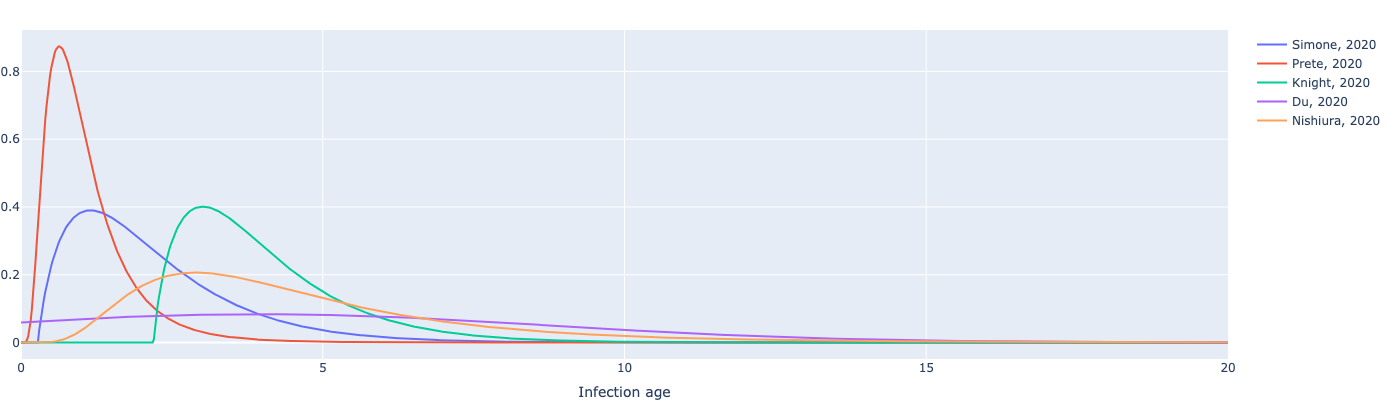

In [80]:
#\snippet{data-serial-intervals-overview}{Serial interval overview figure}
class SerialIntervalsOverviewFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure([
            simone_si.get_trace(),
            prete_si.get_trace(),
            knight_si.get_trace(),
            du_si.get_trace(),
            nishiura_si.get_trace()
        ])

        fig.update_xaxes(title=r"Infection age")

        super().__init__(fig)

SerialIntervalsOverviewFigure() \
    .save("data-serial-intervals-overview") \
    .show()

In [97]:
# TODO: make Hyperparameters class
a_max = 15
nishiura_si.as_weights(a_max)

np.arange(1, a_max + 1).dot(nishiura_si.as_weights(a_max))

5.542764509386419

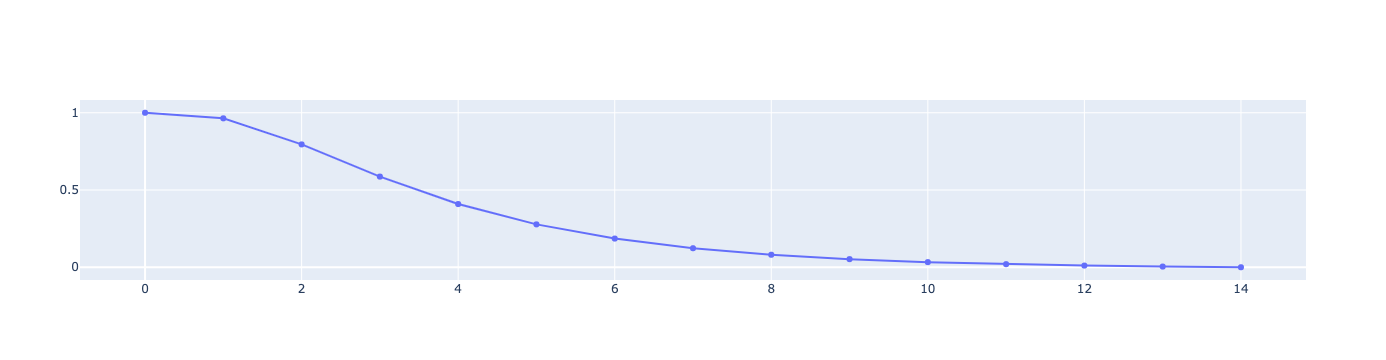

In [100]:
w = nishiura_si.as_weights(a_max)
xx = np.arange(0, a_max)

fig = go.Figure([go.Scatter(x=xx, y=1 - np.cumsum(w))])
fig.show()

In [83]:
#\snippet{data-incidence}{Dynamic incidence data obtaining and storing}

# source URL
DATA_URL = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.min.json"

response = requests.get(url=DATA_URL)
records_by_district = defaultdict(list)

for record in response.json()["data"]:
    district_lau = record["okres_lau_kod"]

    # skip records with no district
    if not district_lau:
        continue

    row = dict(
        date=convert_to_date(record["datum"]),
        Y_C=record["kumulativni_pocet_nakazenych"],
        Y_R=record["kumulativni_pocet_vylecenych"],
        Y_D=record["kumulativni_pocet_umrti"])

    records_by_district[district_lau].append(row)

for key, node in data_nodes.items():
    records = records_by_district[node.nuts]
    records = sorted(records, key=lambda x: x["date"])
    
    index = list(map(lambda x: x["date"], records))[1:]
    Y_C_full = np.array(list(map(lambda x: x["Y_C"], records)))
    Y_R_full = np.array(list(map(lambda x: x["Y_R"], records)))
    Y_D_full = np.array(list(map(lambda x: x["Y_D"], records)))

    node.measurements = DataNodeMeasurements(
        index=index,
        Y_C=Y_C_full[1:],
        Y_R=Y_R_full[1:],
        Y_D=Y_D_full[1:],
        Y_C0=Y_C_full[0],
        Y_R0=Y_R_full[0],
        Y_D0=Y_D_full[0],
        Y_dC=np.diff(Y_C_full),
        Y_dR=np.diff(Y_R_full),
        Y_dD=np.diff(Y_D_full))

In [84]:
#\snippet{data-node-instances}{Make shorthands for data nodes of 3 largest cities in the Czechia}
prague_node = data_nodes["CZ0100"]
brno_node = data_nodes["CZ0642"]
ostrava_node = data_nodes["CZ0806"]

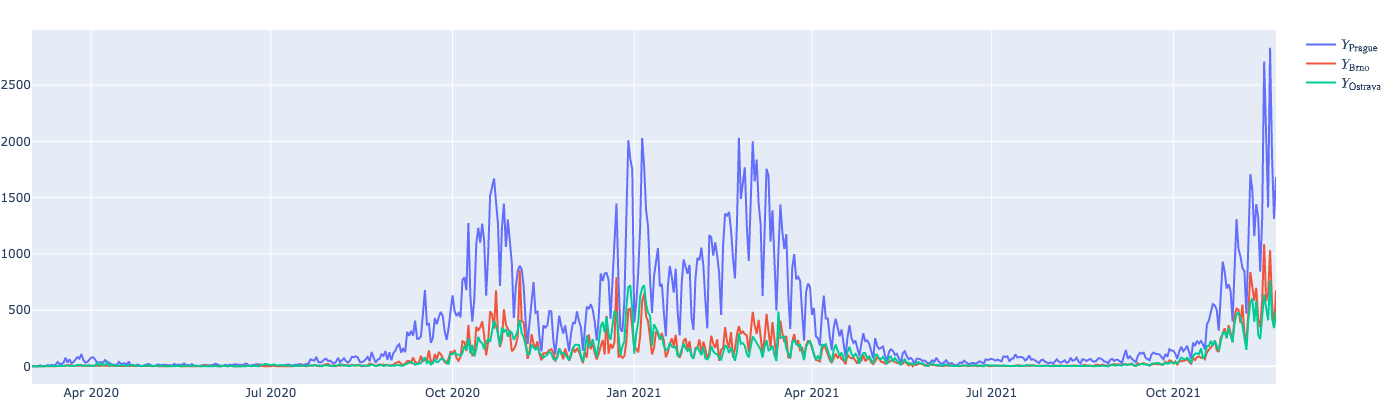

In [23]:
#\snippet{data-largest-cities-plot}{Plot of incidence in the largest cities}
class LargestCitiesIncidenceFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=prague_node.measurements.index, 
                y=prague_node.measurements.Y_dC, 
                name=r"$Y_{\text{Prague}}$"))
        fig.add_trace(
            go.Scatter(
                x=brno_node.measurements.index, 
                y=brno_node.measurements.Y_dC, 
                name=r"$Y_{\text{Brno}}$"))
        fig.add_trace(
            go.Scatter(
                x=ostrava_node.measurements.index, 
                y=ostrava_node.measurements.Y_dC, 
                name=r"$Y_{\text{Ostrava}}$"))

        super().__init__(fig)

LargestCitiesIncidenceFigure() \
    .save("data-largest-cities-plot") \
    .show()

## Data analysis

In [237]:
#\snippet{data-adf-test-prague}{ADF test for Prague incidence data}
table = adf_test(
    prague_node.measurements.Y_dC,
    "data-adf-test-prague",
    "ADF stationarity test for Prague incidence data")

table.show().save()

\begin{table}[H]
\begin{tabularx}{\textwidth}{XXX}
\toprule
\midrule
ADF Statistic &  & -1.522 \\
p-value &  & 0.523 \\
Critical Values &  &  \\
 & 1\% & -3.441 \\
 & 5\% & -2.866 \\
 & 10\% & -2.569 \\
\bottomrule
\end{tabularx}
\caption{ADF stationarity test for Prague incidence data}
\label{tab:data-adf-test-prague}
\end{table}



In [26]:
#\snippet{data-adf-test-brno-ostrava}{ADF test for Brno and Ostrava incidence data}
table = adf_test(
    brno_node.measurements.Y_dC,
    "data-adf-test-brno",
    "ADF stationarity test for Brno incidence data")

table.show().save()

table = adf_test(
    ostrava_node.measurements.Y_dC, 
    "data-adf-test-ostrava", 
    "ADF stationarity test for Ostrava incidence data")

table.show().save()

\begin{table}
\begin{tabularx}{\textwidth}{XXX}
\toprule
\midrule
ADF Statistic &  & -1.292 \\
p-value &  & 0.633 \\
Critical Values &  &  \\
 & 1\% & -3.441 \\
 & 5\% & -2.866 \\
 & 10\% & -2.569 \\
\bottomrule
\end{tabularx}
\caption{ADF stationarity test for Brno incidence data}
\label{tab:data-adf-test-brno}
\end{table}

\begin{table}
\begin{tabularx}{\textwidth}{XXX}
\toprule
\midrule
ADF Statistic &  & -1.565 \\
p-value &  & 0.501 \\
Critical Values &  &  \\
 & 1\% & -3.441 \\
 & 5\% & -2.866 \\
 & 10\% & -2.569 \\
\bottomrule
\end{tabularx}
\caption{ADF stationarity test for Ostrava incidence data}
\label{tab:data-adf-test-ostrava}
\end{table}



In [27]:
#\snippet{data-seasonal-decomposition-figure}{Class for seasonal decomposition plots}
class SeasonalDecompositionFigure(PlotlyFigure):
    def __init__(self, x, data, model: str):
        # add 1 to avoid zero division in multiplicative model
        res = seasonal_decompose(data + 1, model=model, period=7)

        fig = make_subplots(rows=3, cols=1)
        fig.add_trace(
            go.Scatter(x=x, y=data, name=r"$Y$"),
            col=1,
            row=1)
        fig.add_trace(
            go.Scatter(x=x, y=res.trend, name=r"$T$"),
            col=1, 
            row=1)
        fig.add_trace(
            go.Scatter(x=x, y=res.seasonal, name=r"$S$"),
            col=1,
            row=2)
        fig.add_trace(
            go.Scatter(x=x, y=res.resid, name=r"$\epsilon$"),
            col=1,
            row=3)

        super().__init__(fig)

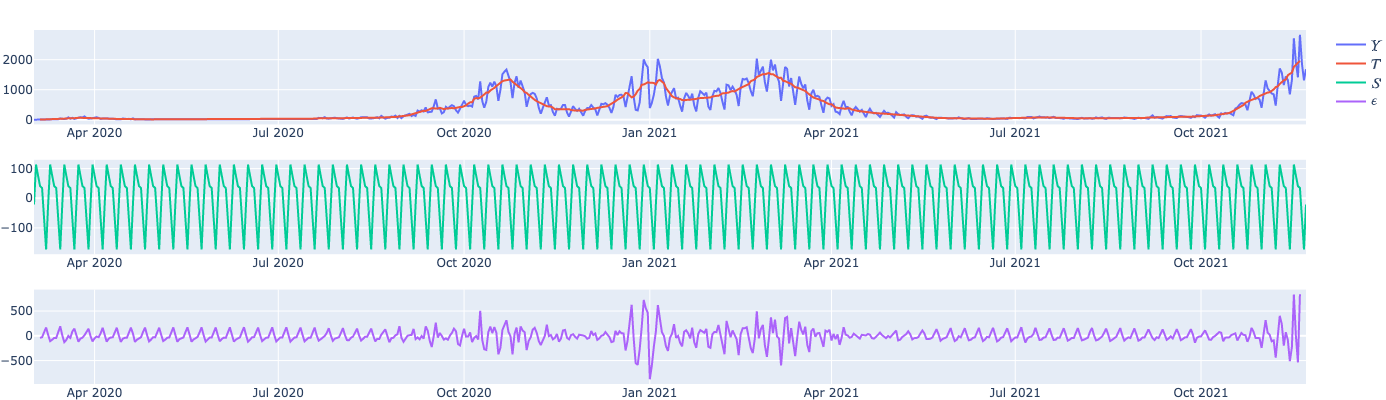

In [29]:
#\snippet{data-seasonal-decomposition-additive}{Additive seasonal decomposition plot}
figure = SeasonalDecompositionFigure(
    prague_node.measurements.index, 
    prague_node.measurements.Y_dC, 
    "additive")

figure \
    .save("data-seasonal-decomposition-additive") \
    .show()

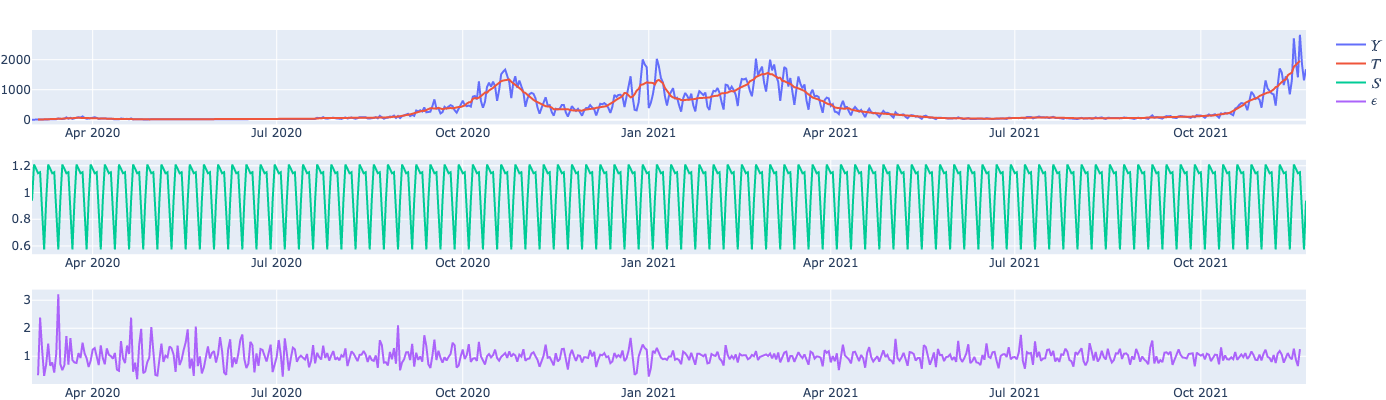

In [30]:
#\snippet{data-seasonal-decomposition-multiplicative}{Multiplicative seasonal decomposition plot}
figure = SeasonalDecompositionFigure(
    prague_node.measurements.index, 
    prague_node.measurements.Y_dC, 
    "multiplicative")

figure \
    .save("data-seasonal-decomposition-multiplicative") \
    .show()

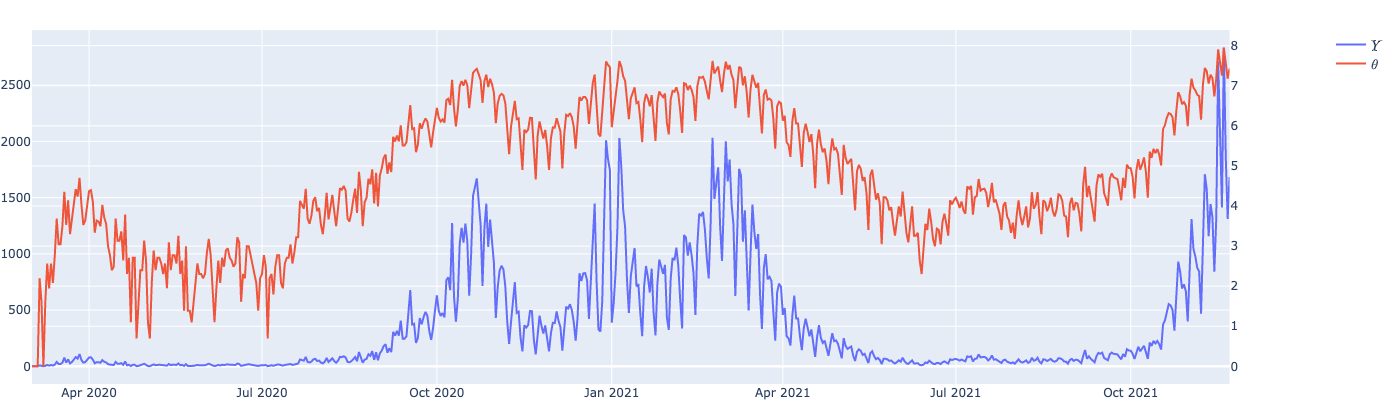

In [32]:
#\snippet{incidence-log-transform-plot}{Plot the comparison between incidence and its log}
# add +1 to avoid log of zero
theta = np.log(prague_node.measurements.Y_dC + 1)

class IncidenceLogTransformFigure(PlotlyFigure):
    def __init__(self):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.add_trace(
            go.Scatter(
                x=prague_node.measurements.index,
                y=prague_node.measurements.Y_dC,
                name=r"$Y$"),
            secondary_y=False)

        fig.add_trace(
            go.Scatter(
                x=prague_node.measurements.index,
                y=theta,
                name=r"$\theta$"),
            secondary_y=True)

        super().__init__(fig)

IncidenceLogTransformFigure() \
    .save("incidence-log-transform") \
    .show()

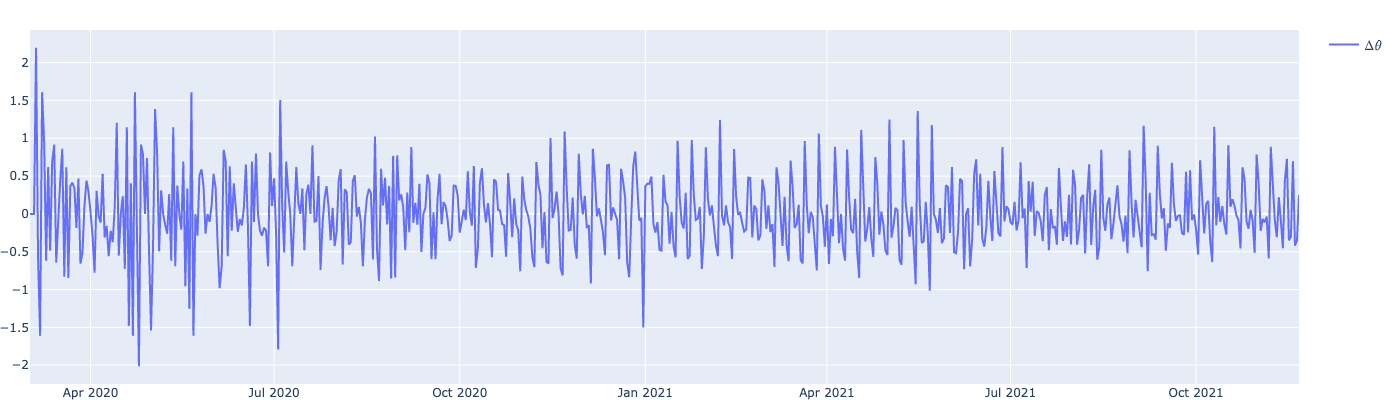

In [34]:
#\snippet{theta-diff-plot}{Plot of the $\Delta \theta$}
theta_diff = np.diff(theta)

class ThetaDiffFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=prague_node.measurements.index,
                y=theta_diff,
                name=r"$\Delta \theta$"))
        fig.update_layout(showlegend=True)

        super().__init__(fig)

ThetaDiffFigure() \
    .save("theta-diff") \
    .show()

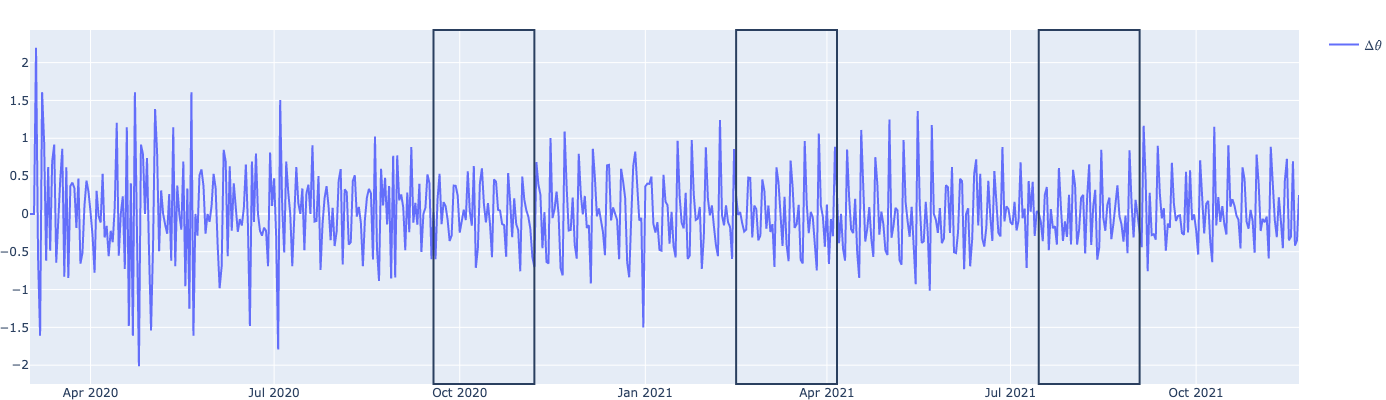

In [36]:
#\snippet{theta-diff-sample-windows-plot}{Plot of the chosen samples of $\Delta \theta$}
window_size = 50
theta_sample_start_indexes = [200, 350, 500]

class ThetaDiffSampleWindowsFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=prague_node.measurements.index, 
                y=theta_diff, 
                name=r"$\Delta \theta$"))
        fig.update_layout(showlegend=True)

        for index in theta_sample_start_indexes:
            fig.add_vrect(
                x0=prague_node.measurements.index[index],
                x1=prague_node.measurements.index[index + window_size])

        super().__init__(fig)

ThetaDiffSampleWindowsFigure() \
    .save("theta-diff-sample-windows") \
    .show()

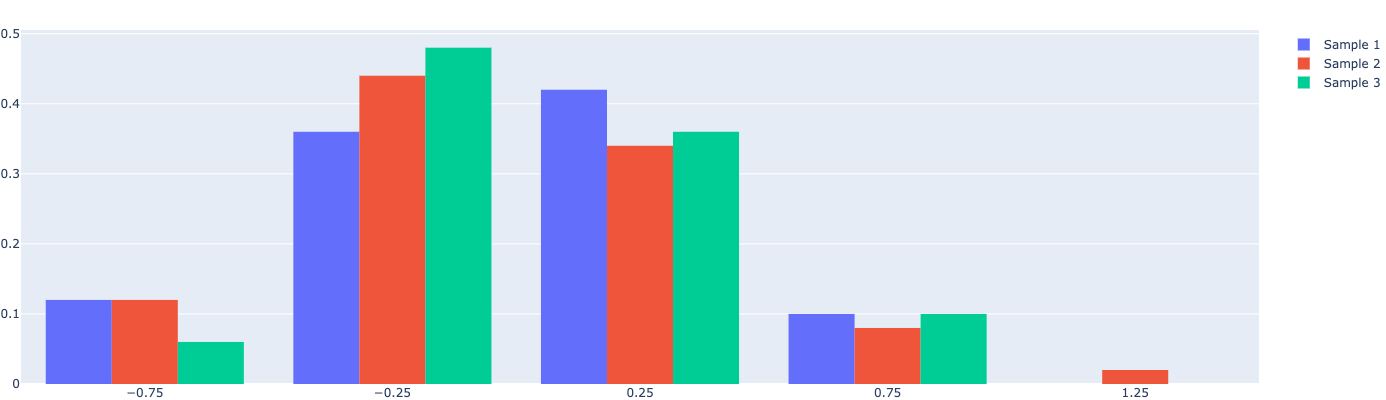

In [37]:
#\snippet{theta-diff-histogram}{Plot the histogram of $\Delta \theta$}
theta_diff_samples = [
    theta_diff[index:index + window_size] for index in theta_sample_start_indexes]

class ThetaDiffHistogramFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        for i, diffs in enumerate(theta_diff_samples, start=1):
            fig.add_trace(go.Histogram(
                x=diffs,
                histnorm="probability",
                xbins=dict(size=0.5),
                name="Sample {}".format(i)))

        super().__init__(fig)

ThetaDiffHistogramFigure() \
    .save("theta-diff-histogram") \
    .show()

/Users/stepanskovajsa/.local/share/virtualenvs/mthesis-GtPzmeXw/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.

/Users/stepanskovajsa/.local/share/virtualenvs/mthesis-GtPzmeXw/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.

/Users/stepanskovajsa/.local/share/virtualenvs/mthesis-GtPzmeXw/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



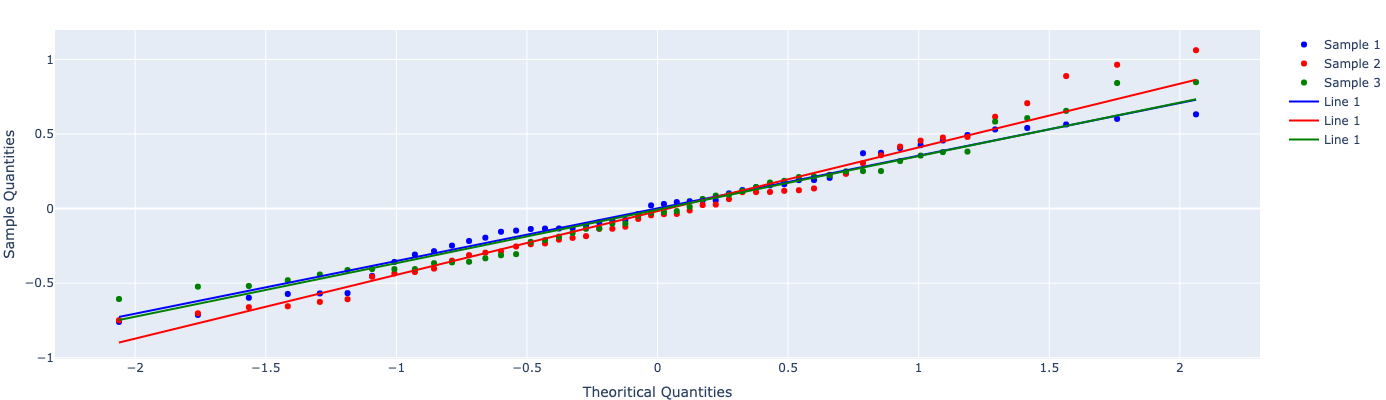

In [38]:
#\snippet{theta-diff-qq-plot}{Q-Q plot of $\Delta \theta$}
qqplots = []
for diffs in theta_diff_samples:
    entry = qqplot(diffs, line='s').gca().lines
    plt.close()
    qqplots.append(entry)

class ThetaDiffQQFigure(PlotlyFigure):
    def __init__(self, colors=["blue", "red", "green"]):
        fig = go.Figure()

        for i, (qqplot, color) in enumerate(zip(qqplots, colors), start=1):
            fig.add_trace({
                'type': 'scatter',
                'x': qqplot[0].get_xdata(),
                'y': qqplot[0].get_ydata(),
                'mode': 'markers',
                'name': 'Sample {}'.format(i),
                'marker': {
                    'color': color
                }
            })

        for i, (qqplot, color) in enumerate(zip(qqplots, colors), start=1):
            fig.add_trace({
                'type': 'scatter',
                'x': qqplot[1].get_xdata(),
                'y': qqplot[1].get_ydata(),
                'mode': 'lines',
                'name': 'Line 1',
                'line': {
                    'color': color
                }
            })

        fig['layout'].update({
            # 'title': 'Quantile-Quantile Plot',
            'xaxis': {
                'title': 'Theoritical Quantities',
                'zeroline': False
            },
            'yaxis': {
                'title': 'Sample Quantities'
            },
            'width': 800,
            'height': 700,
        })

        super().__init__(fig)

ThetaDiffQQFigure().save("theta-diff-qq").show()

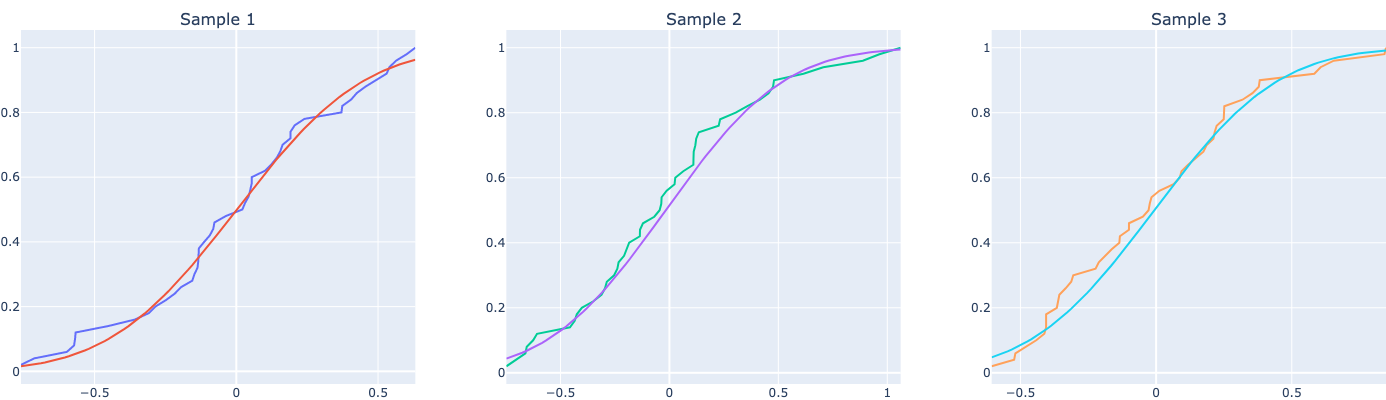

In [39]:
#\snippet{theta-diff-ecdf-plot}{Plot the Empirical CDF of $\Delta \theta$}
class ThetaDiffECDF(PlotlyFigure):
    def __init__(self):
        titles = ["Sample {}".format(i + 1) for i in range(len(theta_diff_samples))]
        fig = make_subplots(rows=1, cols=3, subplot_titles=titles)

        for col, sample in enumerate(theta_diff_samples, start=1):
            xx = np.linspace(np.min(sample), np.max(sample), 100)
            m = sample.mean()
            sd = sample.std()

            pt_sorted = np.sort(sample)
            ys = np.arange(1, len(pt_sorted) + 1) / float(len(pt_sorted))

            fig.add_trace(
                go.Scatter(x=pt_sorted, y=ys), 
                row=1, 
                col=col)
            fig.add_trace(
                go.Scatter(x=xx, y=st.norm(m, sd).cdf(xx)), 
                row=1, 
                col=col)

        fig.update_layout(showlegend=False)

        super().__init__(fig)

ThetaDiffECDF().save("theta-diff-ecdf").show()

In [40]:
#\snippet{theta-diff-ks-test}{Kolmogorov–Smirnov normality test on $\Delta \theta$}
table = LaTeXTable(
    table_name="theta-diff-ks-test",
    caption="Results of the Kolmogorov–Smirnov normality test for each sample",
    columns=["", "Statistic", "p-value"])

for i, sample in enumerate(theta_diff_samples, start=1):
    res = st.kstest(sample, 'norm')

    table.add_row(
        ["Sample {}:".format(i), "%.3f" % res.statistic, "%.3f" % res.pvalue])

table.show().save()

\begin{table}
\begin{tabularx}{\textwidth}{XXX}
\toprule
 & Statistic & p-value \\
\midrule
Sample 1: & 0.264 & 0.001 \\
Sample 2: & 0.227 & 0.010 \\
Sample 3: & 0.280 & 0.001 \\
\bottomrule
\end{tabularx}
\caption{Results of the Kolmogorov–Smirnov normality test for each sample}
\label{tab:theta-diff-ks-test}
\end{table}



In [41]:
#\snippet{theta-diff-lilliefors-test}{Lilliefors normality test on $\Delta \theta$}
table = LaTeXTable(
    table_name="theta-diff-lilliefors-test",
    caption="Results of the Lilliefors normality test for each sample",
    columns=["", "Statistic", "p-value"])

for i, sample in enumerate(theta_diff_samples, start=1):
    stat, pvalue = lilliefors(sample, dist='norm', pvalmethod='approx')

    table.add_row(
        ["Sample {}:".format(i), "%.3f" % stat, "%.3f" % pvalue])

table.show().save()

\begin{table}
\begin{tabularx}{\textwidth}{XXX}
\toprule
 & Statistic & p-value \\
\midrule
Sample 1: & 0.070 & 0.778 \\
Sample 2: & 0.102 & 0.218 \\
Sample 3: & 0.095 & 0.319 \\
\bottomrule
\end{tabularx}
\caption{Results of the Lilliefors normality test for each sample}
\label{tab:theta-diff-lilliefors-test}
\end{table}



In [42]:
#\snippet{theta-diff-shapiro-wilk-test}{Shapiro-Wilk normality test on $\Delta \theta$}
table = LaTeXTable(
    table_name="theta-diff-shapiro-wilk-test",
    caption="Results of the Shapiro-Wilk normality test for each sample",
    columns=["", "Statistic", "p-value"])

# Shapiro-Wilk test for normality
for i, sample in enumerate(theta_diff_samples, start=1):
    res = st.shapiro(sample)
    table.add_row(
        ["Sample {}:".format(i), "%.3f" % res.statistic, "%.3f" % res.pvalue])

table.show().save()

\begin{table}
\begin{tabularx}{\textwidth}{XXX}
\toprule
 & Statistic & p-value \\
\midrule
Sample 1: & 0.974 & 0.321 \\
Sample 2: & 0.969 & 0.210 \\
Sample 3: & 0.962 & 0.111 \\
\bottomrule
\end{tabularx}
\caption{Results of the Shapiro-Wilk normality test for each sample}
\label{tab:theta-diff-shapiro-wilk-test}
\end{table}



In [43]:
#\snippet{inc-model-sample-incidence-figure}{Code for creating and plotting samples from the incidence}
def make_incidence_sample(start_index, data):
    return data[start_index:start_index + window_size]

class SampleIncidenceFigure(PlotlyFigure):
    def __init__(self, sample):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=np.arange(window_size), y=sample))

        super().__init__(fig)

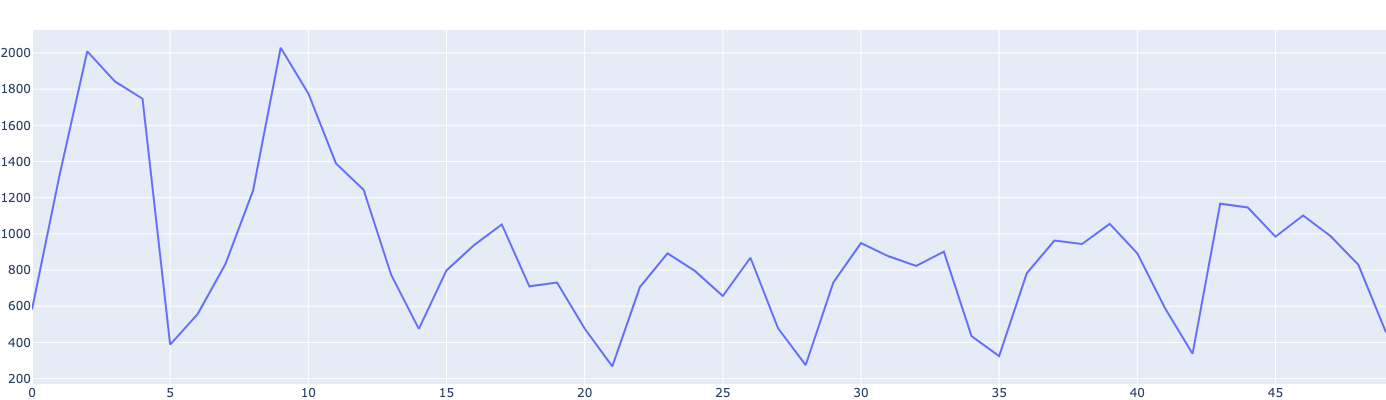

In [44]:
#\snippet{inc-model-sample-incidence-1}{Making and plotting observed incidence sample 1}
incidence_obs_sample1 = make_incidence_sample(300, prague_node.measurements.Y_dC)

SampleIncidenceFigure(incidence_obs_sample1) \
    .save("inc-model-sample-incidence-1") \
    .show()

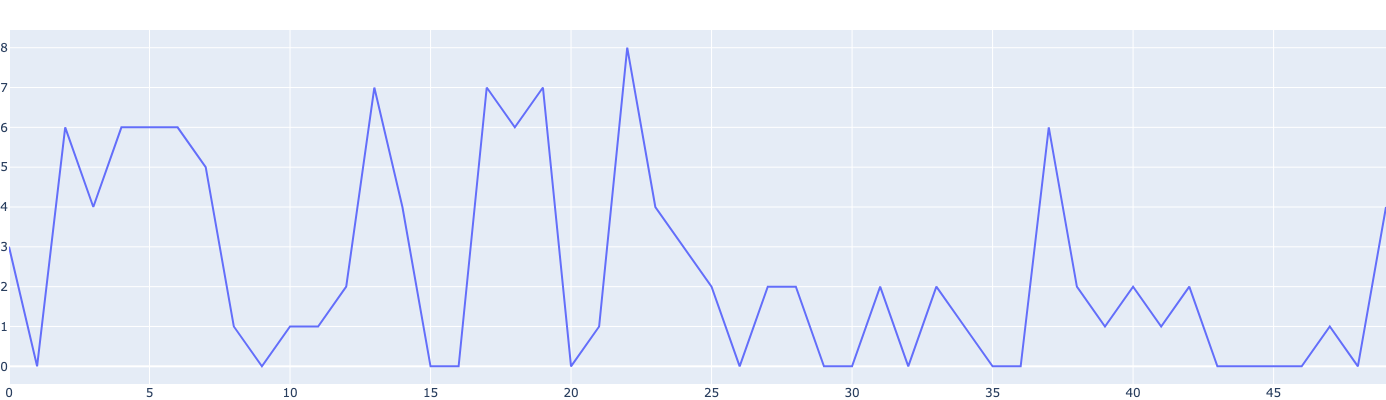

In [45]:
#\snippet{inc-model-sample-incidence-2}{Making and plotting observed incidence sample 2}
incidence_obs_sample2 = make_incidence_sample(60, ostrava_node.measurements.Y_dC)

SampleIncidenceFigure(incidence_obs_sample2) \
    .save("inc-model-sample-incidence-2") \
    .show()

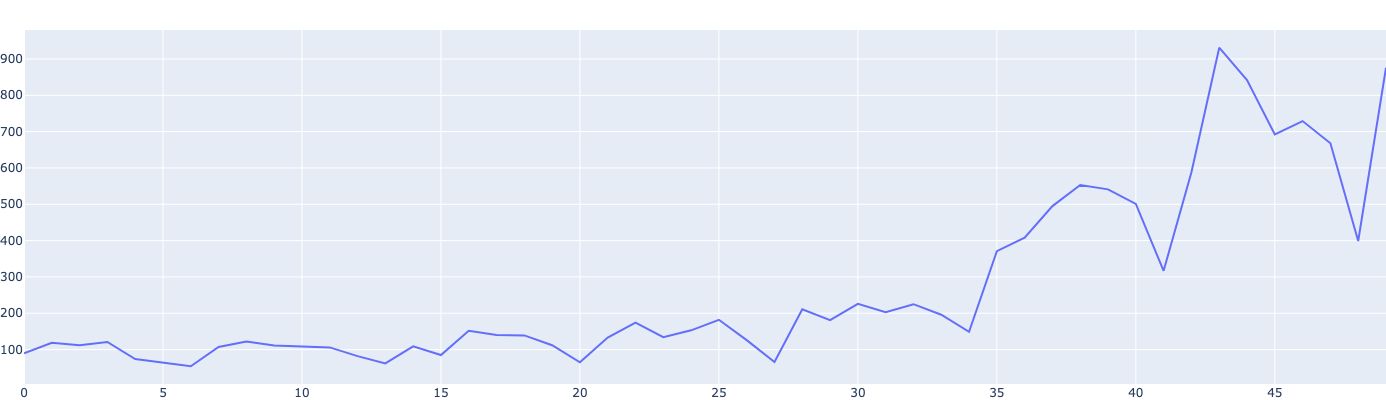

In [47]:
#\snippet{inc-model-sample-incidence-3}{Making and plotting observed incidence sample 3}
incidence_obs_sample3 = make_incidence_sample(560, prague_node.measurements.Y_dC)

SampleIncidenceFigure(incidence_obs_sample3) \
    .save("inc-model-sample-incidence-3") \
    .show()

In [478]:
@dataclass
class Hyperparameters:
    kernel_ls: float = 5.0
    mu_a: float = 0.0
    mu_b: float = 2.0
    sigma_a: float = 0.5
    sigma_b: float = 1.0
    lambda_alpha: float = 2.0
    window_size: int = 50 # T_w
    a_max: int = 15
    si: SerialInterval = field(default=nishiura_si)

hyperparameters = Hyperparameters()

#\snippet{inc-model-build-func}{Creates parametrized model instance}
def build_model(incidence_data, hp: Hyperparameters):
    with pm.Model() as model:
        b = pm.Normal("b", mu=hp.mu_b, sigma=hp.sigma_b)
        a = pm.Normal("a", mu=hp.mu_a, sigma=hp.sigma_a)
        alpha = pm.Exponential("alpha", hp.lambda_alpha)

        mean_func = pm.gp.mean.Linear(coeffs=a, intercept=b)
        # cov_func = eta ** 2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
        cov_func = pm.gp.cov.ExpQuad(1, ls=hp.kernel_ls)

        gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
        theta = gp.prior("theta", X=np.arange(0, len(incidence_data))[:, None])

        incidence = pm.NegativeBinomial(
            "incidence", mu=tt.exp(theta), alpha=alpha, observed=incidence_data)

        return model

In [469]:
#\snippet{inc-model-build-on-samples}{Build model for each specific sample}
model1 = build_model(incidence_obs_sample1, hyperparameters)
model2 = build_model(incidence_obs_sample2, hyperparameters)
model3 = build_model(incidence_obs_sample3, hyperparameters)

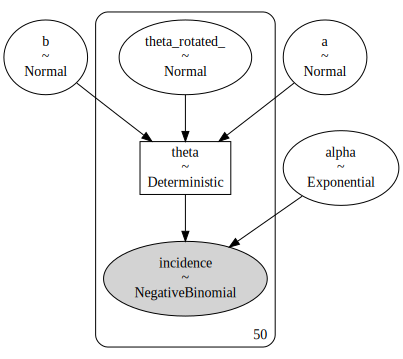

In [470]:
#\snippet{inc-model-graphviz}{Plot the internal PyMC3 representation of the model}
pm.model_to_graphviz(model1)

In [319]:
#\snippet{inc-model-sampling-func}{Inference function (just shorthand)}
def sample_model(model):
    with model:
        return pm.sample(1000, target_accept=0.95, return_inferencedata=True)

In [320]:
#\snippet{inc-model-sampling-1}{Sample model 1 based on the incidence sample 1}
trace1 = sample_model(model1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [321]:
#\snippet{inc-model-sampling-2}{Sample model 2 based on the incidence sample 2}
trace2 = sample_model(model2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [323]:
#\snippet{inc-model-sampling-3}{Sample model 3 based on the incidence sample 3}
trace3 = sample_model(model3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


In [324]:
class IncidenceParamsTraceFigure(MatPlotLibFigure):
    def __init__(self, trace):
        # fig = plt.figure(figsize=(12, 5), dpi=120)
        # ax = fig.gca()
        axes = az.plot_trace(trace1, var_names=["theta", "a", "b", "alpha"], figsize=(15, 10), legend=True)
        fig = axes.ravel()[0].figure
        fig.tight_layout()

        super().__init__(fig)

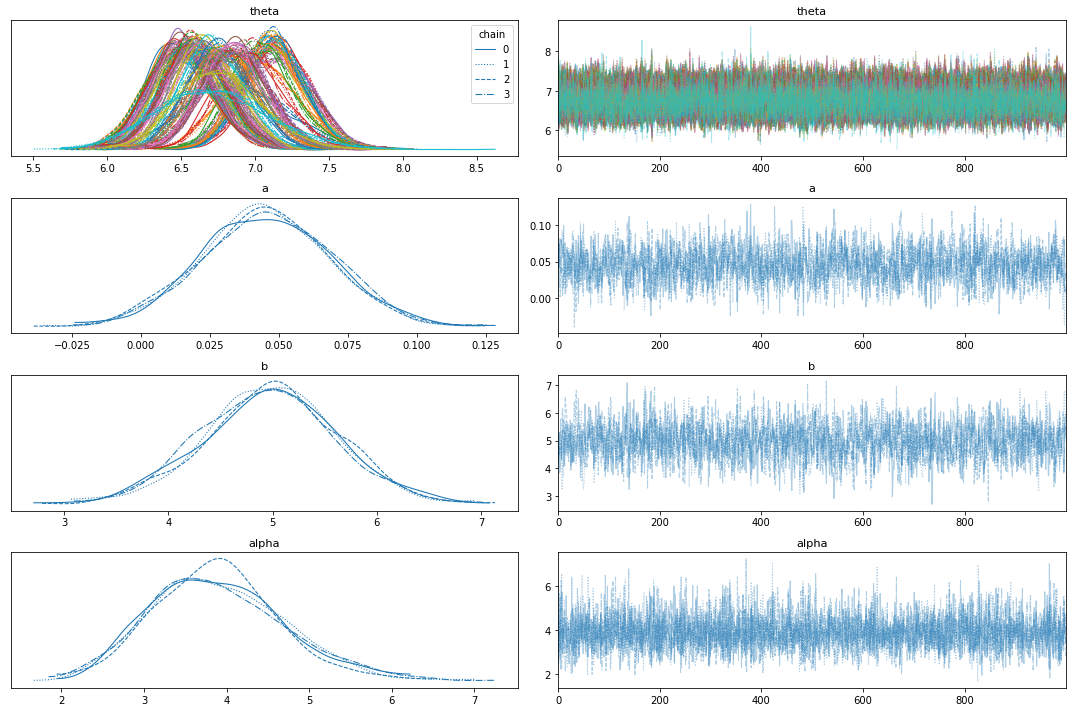

In [325]:
#\snippet{inc-model-sampling-trace-plot-1}{Plotting the trace of model 1 sampling}
# az.plot_trace(trace1, var_names=["theta", "a", "b", "alpha"])
IncidenceParamsTraceFigure(trace1).show().save("inc-model-params-trace-1")

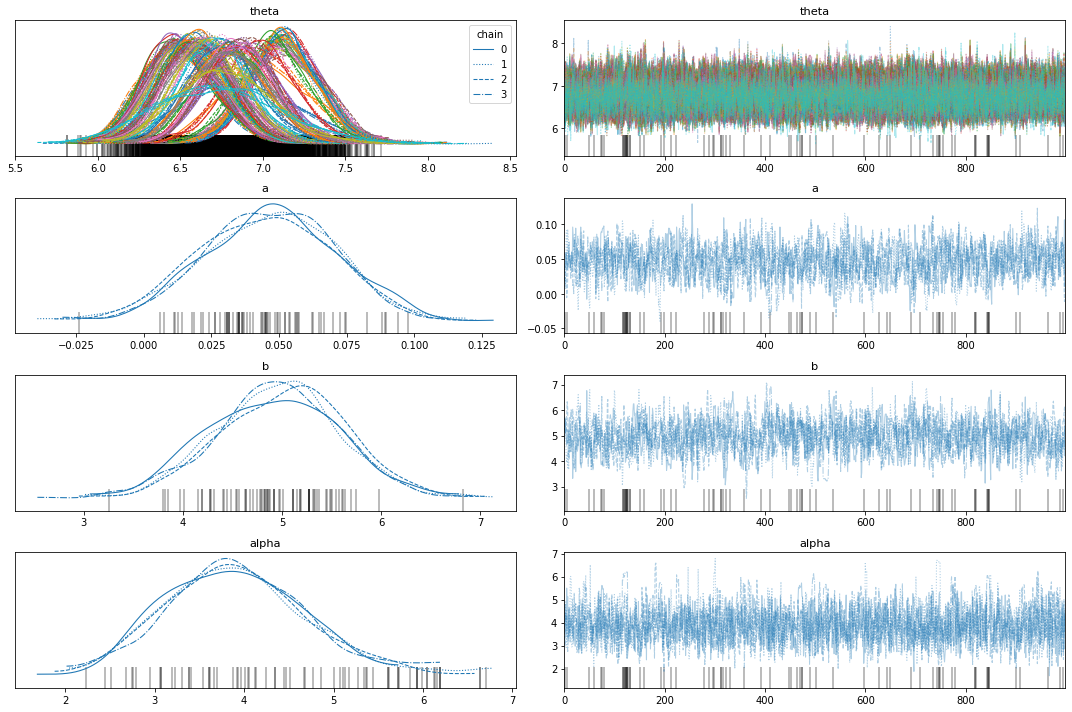

In [312]:
#\snippet{inc-model-sampling-trace-plot-2}{Plotting the trace of model 2 sampling}
# az.plot_trace(trace2, var_names=["theta", "a", "b", "alpha"])

IncidenceParamsTraceFigure(trace2).show().save("inc-model-params-trace-2")

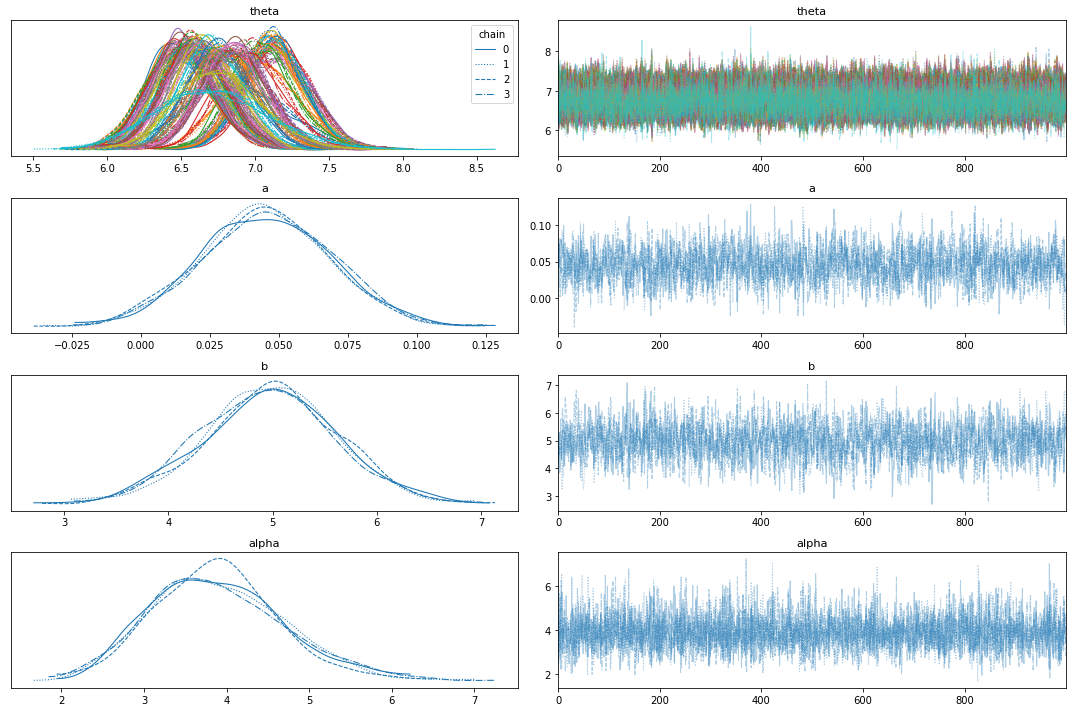

In [326]:
#\snippet{inc-model-sampling-trace-plot-3}{Plotting the trace of model 3 sampling}
# az.plot_trace(trace3, var_names=["theta", "a", "b", "alpha"])

IncidenceParamsTraceFigure(trace3).show().save("inc-model-params-trace-3")

In [327]:
#\snippet{inc-model-theta-posterior-figure}{Posterior of $\theta$ figure}
class ThetaPosteriorFigure(MatPlotLibFigure):
    def __init__(self, trace):
        fig = plt.figure(figsize=(12, 5), dpi=120)
        ax = fig.gca()
        plot_gp_dist(
            ax,
            trace.posterior["theta"][0, :, :],
            np.arange(window_size), 
            palette="plasma")

        super().__init__(fig)

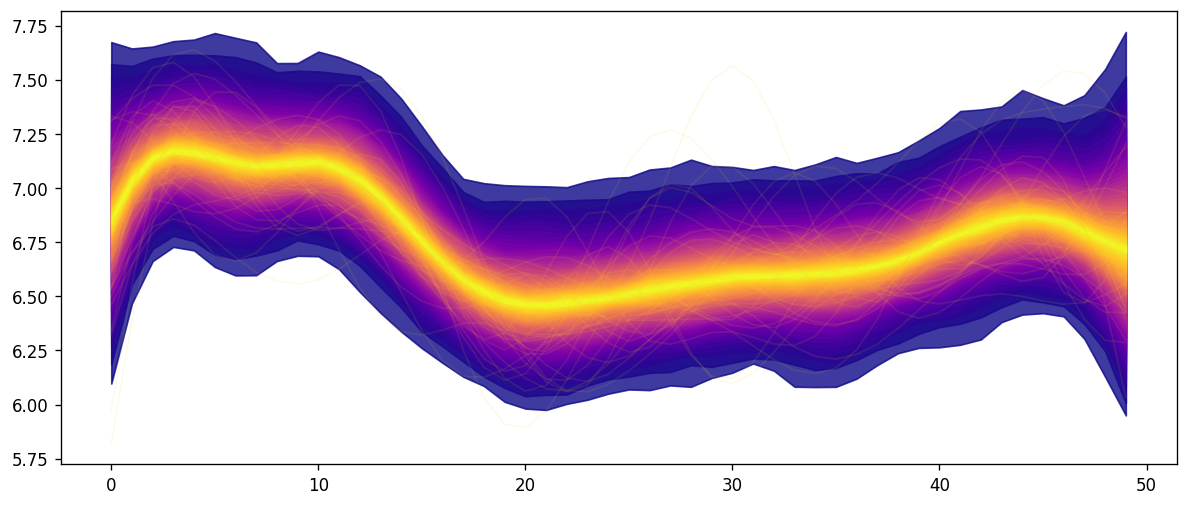

In [328]:
#\snippet{inc-model-theta-posterior-1}{Plotting posterior of $\theta$ in the model 1}
ThetaPosteriorFigure(trace1) \
    .show() \
    .save("inc-model-theta-posterior-1")

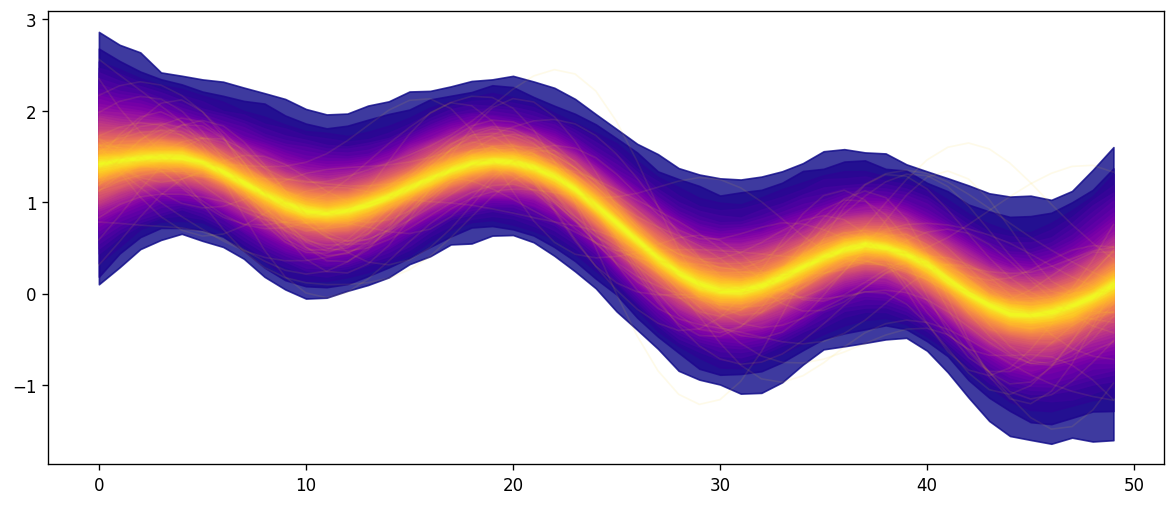

In [329]:
#\snippet{inc-model-theta-posterior-2}{Plotting posterior of $\theta$ in the model 2}
ThetaPosteriorFigure(trace2) \
    .show() \
    .save("inc-model-theta-posterior-2")

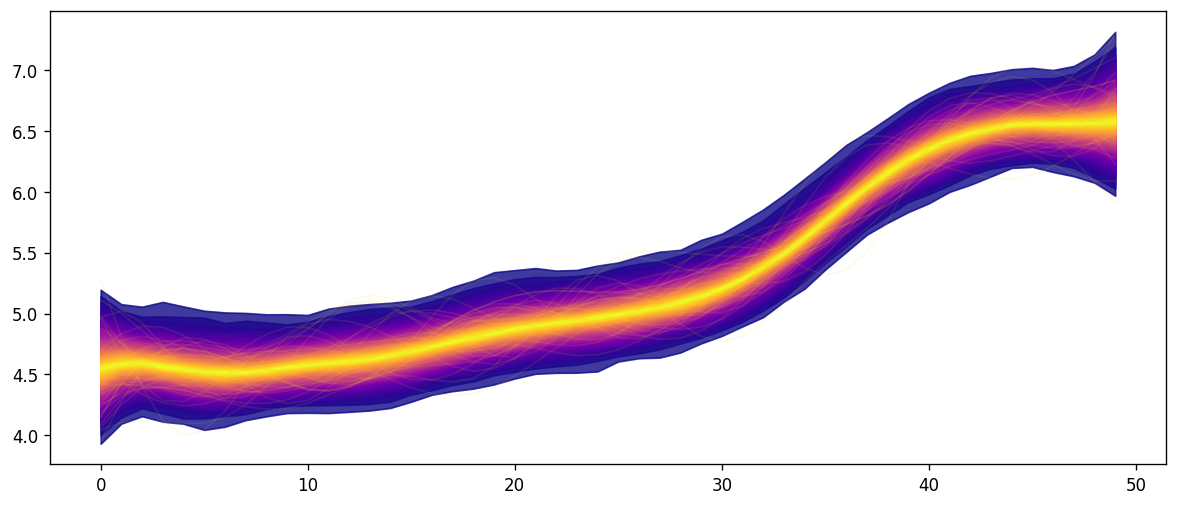

In [330]:
#\snippet{inc-model-theta-posterior-3}{Plotting posterior of $\theta$ in the model 3}
ThetaPosteriorFigure(trace3) \
    .show() \
    .save("inc-model-theta-posterior-3")

In [331]:
#\snippet{inc-model-pp-func}{Function for generating incidence posterior predictive check samples}
def make_posterior_predictive(model, trace):
    with model:
        return pm.sample_posterior_predictive(trace.posterior, var_names=["incidence"])

In [332]:
#\snippet{inc-model-ppc-1}{Generate posterior predictive check samples for model 1}
ppc1 = make_posterior_predictive(model1, trace1)

In [333]:
#\snippet{inc-model-ppc-2}{Generate posterior predictive check samples for model 2}
ppc2 = make_posterior_predictive(model2, trace2)

In [334]:
#\snippet{inc-model-ppc-3}{Generate posterior predictive check samples for model 3}
ppc3 = make_posterior_predictive(model3, trace3)

In [335]:
#\snippet{inc-model-ppc-figure}{Figure of PPC}
class IncidencePosteriorFigure(MatPlotLibFigure):
    def __init__(self, ppc, xx, observed_incidence, true_incidence = None):
        fig = plt.figure(figsize=(10, 5), dpi=120)
        ax = fig.gca()
        plot_gp_dist(
            ax=ax, 
            samples=ppc["incidence"], 
            x=xx, 
            palette="plasma")
        ax.scatter(
            x=xx, 
            y=observed_incidence, 
            color="lime", 
            marker="+", 
            lw=2, 
            label="Observed incidence")
        if true_incidence is not None:
            ax.scatter(
                x=xx, 
                y=true_incidence, 
                color="cyan", 
                marker="x", 
                lw=2, 
                label="True incidence")
        plt.legend()

        super().__init__(fig)

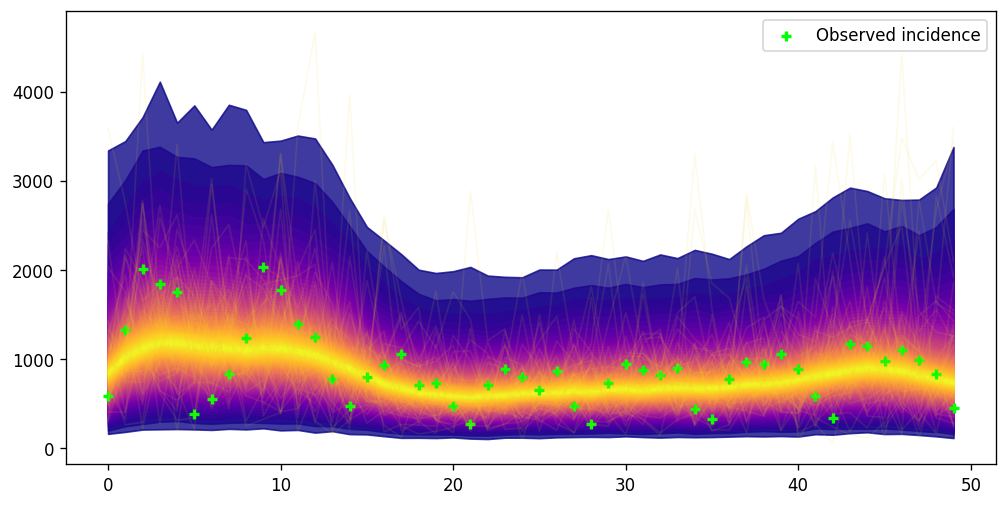

In [336]:
#\snippet{inc-model-ppc-plot-1}{Plot PPC for model 1}
IncidencePosteriorFigure(ppc1, np.arange(len(incidence_obs_sample1)), incidence_obs_sample1) \
    .show() \
    .save("inc-model-ppc-plot-1-zero-mean")

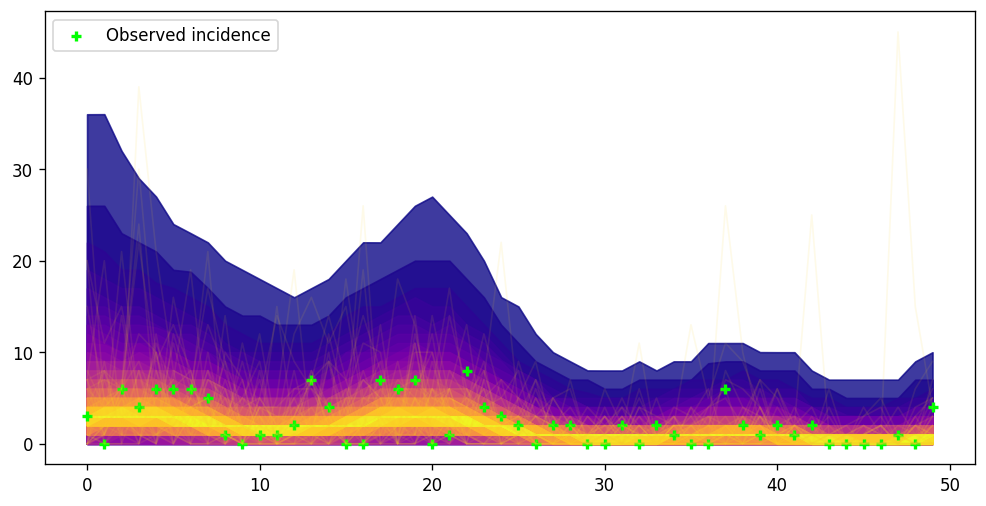

In [337]:
#\snippet{inc-model-ppc-plot-2}{Plot PPC for model 2}
IncidencePosteriorFigure(ppc2, np.arange(len(incidence_obs_sample2)), incidence_obs_sample2) \
    .show() \
    .save("inc-model-ppc-plot-2")

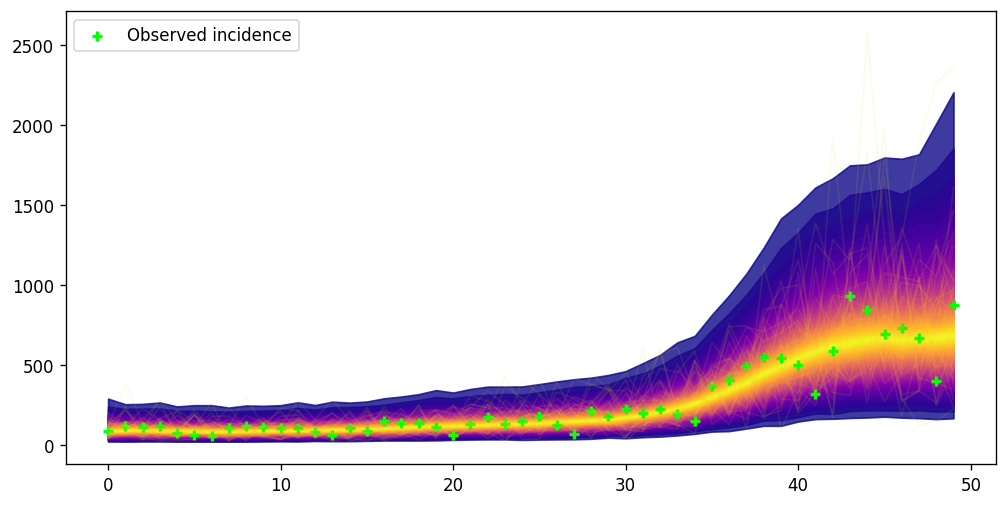

In [338]:
#\snippet{inc-model-ppc-plot-3}{Plot PPC for model 3}
IncidencePosteriorFigure(ppc3, np.arange(len(incidence_obs_sample3)), incidence_obs_sample3) \
    .show() \
    .save("inc-model-ppc-plot-3")

In [479]:
# si_weights = nishiura_si.as_weights(tau_m)
# si_days = np.arange(tau_m)
E_si = hyperparameters.si.expected_value
E_si

4.700000000000026

In [480]:
gamma = 1 / E_si
gamma

0.21276595744680735

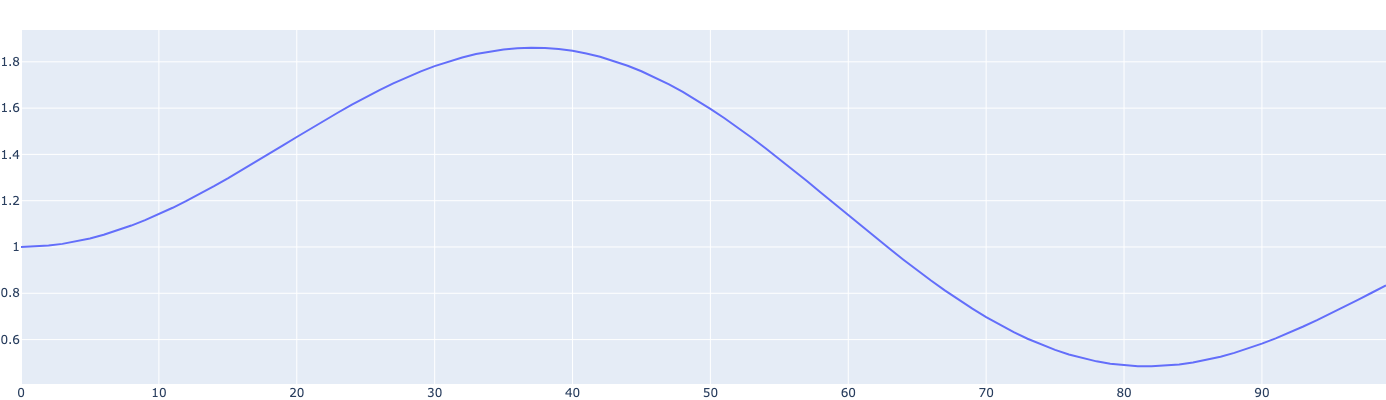

In [414]:
test_days = np.arange(2 * hyperparameters.window_size)
# y=2-0.001\left(x-20\right)^{2}+\sin\left(0.3x\right)
Rt_ts = 1 + np.sin(0.03 * test_days) * np.sin(0.05 * test_days)

class RiskModelFakeRtFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=test_days, y=Rt_ts, name=r"$\mathcal{R}_t$"))

        super().__init__(fig)

RiskModelFakeRtFigure().save("risk-model-fake-rt").show()

In [434]:
# incidence_samples = [
#     prague_node.measurements.Y_dC[index:index + window_size] for index in theta_sample_start_indexes]

# variances = [np.var(sample) for sample in incidence_samples]
# np.sqrt(variances)
# incidence_samples

array([11.05820521,  7.62471989, 10.18872882,  9.6866415 , 16.64272682,
       23.92965054, 10.10107308, 24.96353707, 27.86489645, 11.47326651])

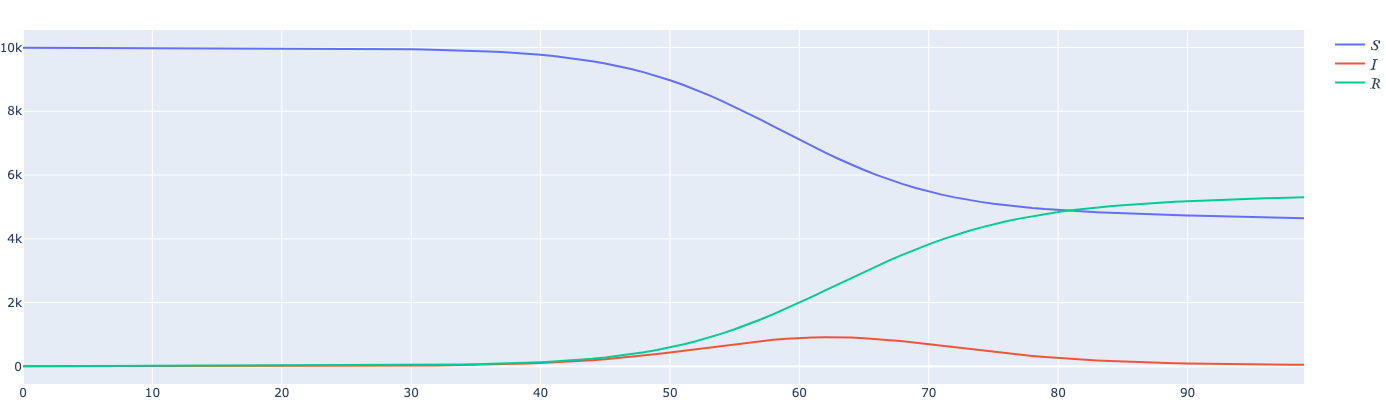

In [443]:
N = 10000
I = 6
S = N - I
R = 0

tss = []

for i in test_days:
    true_inc = int(I * gamma * Rt_ts[i])
    restored = int(I * gamma)

    S -= true_inc
    I += true_inc - restored
    R += restored

    # m = true_inc
    # sigma = max(0.4 * m + 1, 1)
    # # print(np.clip((sigma ** 2 - m), 1, None))
    # n = m ** 2 / (sigma ** 2 - m)
    # p = m / (sigma ** 2)
    # print("n", n)
    # print("p", p)
    
    obs_inc = int(abs(st.norm(true_inc, true_inc * 0.25).rvs()))

    np.sqrt(np.exp(v.rvs(10)))

    # obs_inc = true_inc
    tss.append((S, I, R, true_inc, obs_inc))

S, I, R, true_inc, obs_inc = zip(*tss)

class RiskModelFakeSIRFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=test_days, y=S, name=r"$S$"))
        fig.add_trace(go.Scatter(x=test_days, y=I, name=r"$I$"))
        fig.add_trace(go.Scatter(x=test_days, y=R, name=r"$R$"))

        super().__init__(fig)

RiskModelFakeSIRFigure().save("risk-model-fake-sir").show()

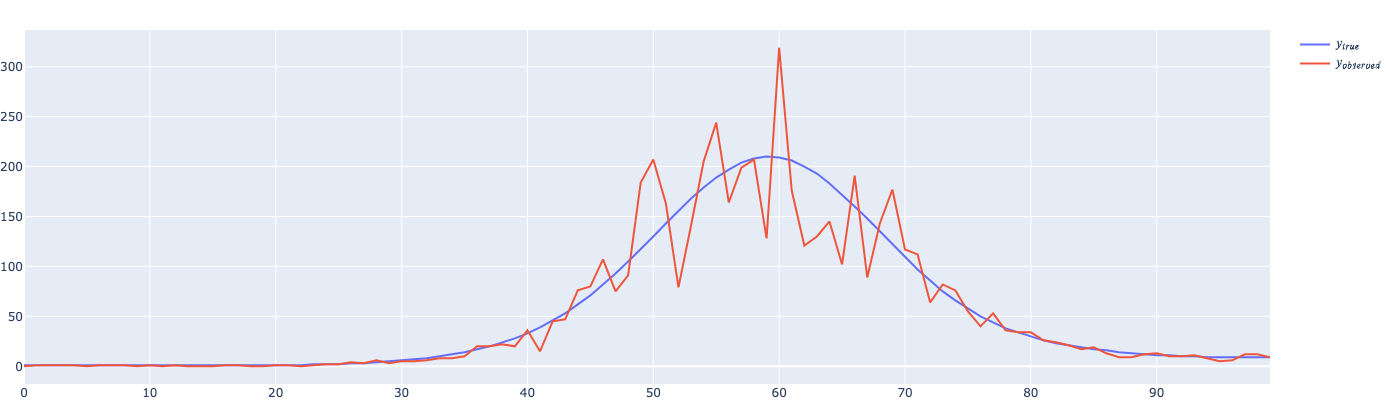

In [444]:
class RiskModelFakeIncidence(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=test_days, y=true_inc, name=r"$y_{true}$"))
        fig.add_trace(go.Scatter(x=test_days, y=obs_inc, name=r"$y_{observed}$"))

        super().__init__(fig)

RiskModelFakeIncidence().save("risk-model-fake-incidence").show()

In [473]:
t_1 = 80

obs_inc_window = obs_inc[t_1 - hyperparameters.window_size:t_1]
true_inc_window = true_inc[t_1 - hyperparameters.window_size:t_1]

model = build_model(obs_inc_window, hyperparameters)
trace = sample_model(model)
ppc = make_posterior_predictive(model, trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


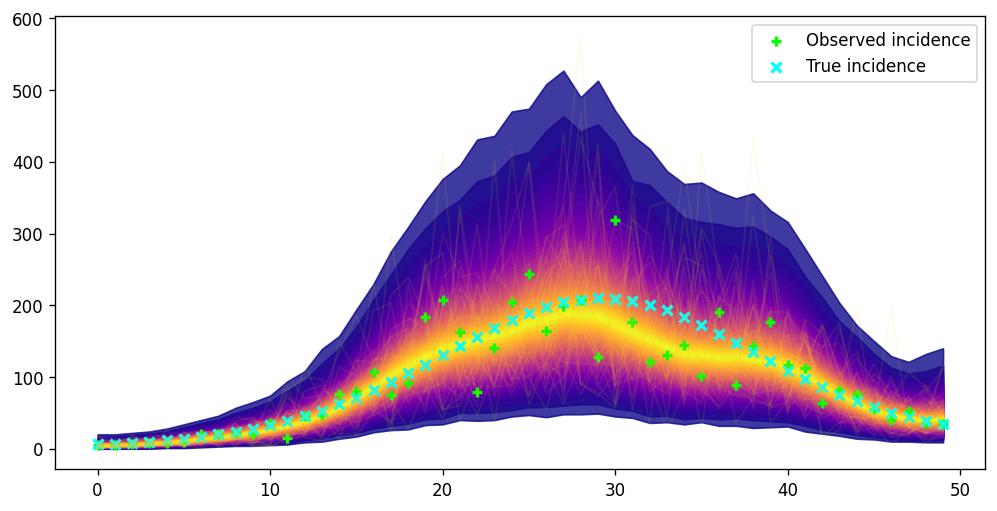

In [474]:
IncidencePosteriorFigure(ppc, np.arange(len(obs_inc_window)), obs_inc_window, true_inc_window) \
    .show() \
    .save("risk-model-incidence-posterior-predictive")

In [514]:
def make_prevalence_matrix(A, hp: Hyperparameters):
#     B = np.ones((A.shape[0], A.shape[1]))

#     si_weights = hp.si.as_weights(hp.a_max)
#     Omega = 1 - np.cumsum(si_weights)

#     for t in range(F_len, A.shape[1]):
#         for i in range(A.shape[0]):
#             b = 1

#             for j in range(len(Omega)):
#                 b += A[i, t - j] * Omega[j]

#             B[i, t] = b

    B = np.zeros((A.shape[0], A.shape[1] - hp.a_max))

    si_weights = hp.si.as_weights(hp.a_max)
    Omega = 1 - np.cumsum(si_weights)

    for t in range(0, A.shape[1] - hp.a_max):
        for i in range(A.shape[0]):
            # theoretically, we always have at least one infectious
            b = 1

            for j in range(len(Omega)):
                b += A[i, hp.a_max + t - j] * Omega[j]

            B[i, t] = b

    return B

prevalence_mat = make_prevalence_matrix(ppc["incidence"], hyperparameters)
prevalence_mat

array([[157.56272623, 196.28252878, 226.67393649, ..., 323.39145666,
        297.40866509, 271.21684458],
       [232.87796915, 279.67180711, 345.7783879 , ..., 221.93615581,
        200.45491407, 207.41663783],
       [231.61279842, 282.86367359, 348.95758772, ..., 425.59458912,
        338.8580715 , 282.5577767 ],
       ...,
       [168.61089654, 196.36506978, 278.98942334, ..., 324.87088451,
        327.15202506, 388.51841507],
       [109.85137713, 118.0777692 , 223.93758895, ..., 342.3385902 ,
        275.74486308, 257.83183551],
       [224.27444188, 254.70329808, 347.3360925 , ..., 214.39987679,
        203.62786228, 244.58821565]])

In [512]:
def get_quantile_traces(xx, values, title, quantiles=[0.75, 0.95]):
    median = np.median(values, axis=1)
    traces = []

    for quantile in quantiles:
        a = (1 - quantile) / 2
        y_upper = np.quantile(values, q=1 - a, axis=1)
        y_lower = np.quantile(values, q=a, axis=1)

        traces.extend([
            go.Scatter(
                name="{:.0%} CI".format(quantile),
                x=xx,
                y=y_upper,
                mode='lines',
                line=dict(width=0),
                showlegend=True
            ),
            go.Scatter(
                x=xx,
                y=y_lower,
                # marker=dict(color="#444"),
                marker=dict(opacity=0.7),
                line=dict(width=0),
                mode='lines',
                # fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
            )
        ])

    traces.append(go.Scatter(
        name=title,
        x=xx,
        y=median,
        mode='lines',
    ))

    return traces

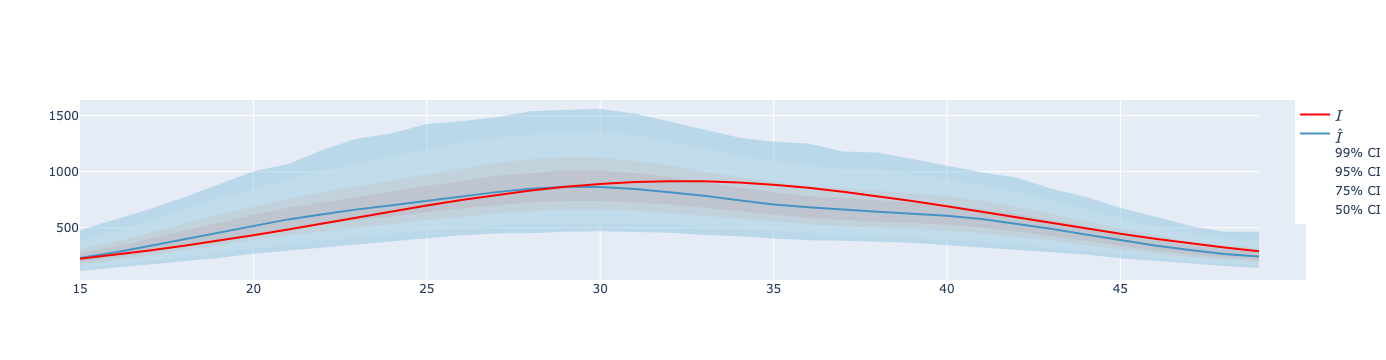

In [513]:
x_ind = np.arange(hyperparameters.a_max, hyperparameters.window_size)

def plot_active_cases_estimation(xx, prevalence_matrix, observed_I):
    layout = go.Layout(colorway=px.colors.sequential.RdBu)
    fig = go.Figure([
        *get_quantile_traces(
            xx,
            prevalence_matrix.T,
            quantiles=[0.5, 0.75, 0.95, 0.99],
            title="$\hat{I}$")
    ], layout=layout)

    if observed_I is not None:
        fig.add_trace(go.Scatter(x=xx, y=observed_I, name=r"$I$", line=dict(color="red")))

    fig.show()

plot_active_cases_estimation(x_ind, prevalence_mat, I[t_1-window_size+hyperparameters.a_max:t_1])

In [515]:
def make_reproduction_number_matrix(A, hp: Hyperparameters):
#     R = np.zeros((A.shape[0], A.shape[1]))
#     omega = hp.si.as_weights(hp.a_max)

#     for t in range(F_len, A.shape[1]):
#         for i in range(A.shape[0]):
#             # b = E_si_remainder * A[i, t - E_si_whole]
#             lambda_ = 0
#             for j in range(hp.a_max):
#                 lambda_ += A[i, t - j] * omega[j]

#             R[i, t] = A[i, t] / lambda_
    R = np.zeros((A.shape[0], A.shape[1] - hp.a_max))
    omega = hp.si.as_weights(hp.a_max)

    for t in range(A.shape[1] - hp.a_max):
        for i in range(A.shape[0]):
            # b = E_si_remainder * A[i, t - E_si_whole]
            t_shifted = hp.a_max + t
            lambda_ = 0
            for j in range(hp.a_max):
                lambda_ += A[i, t_shifted - j] * omega[j]

            R[i, t] = A[i, t_shifted] / lambda_

    return R

R_eff = make_reproduction_number_matrix(ppc["incidence"], hyperparameters)

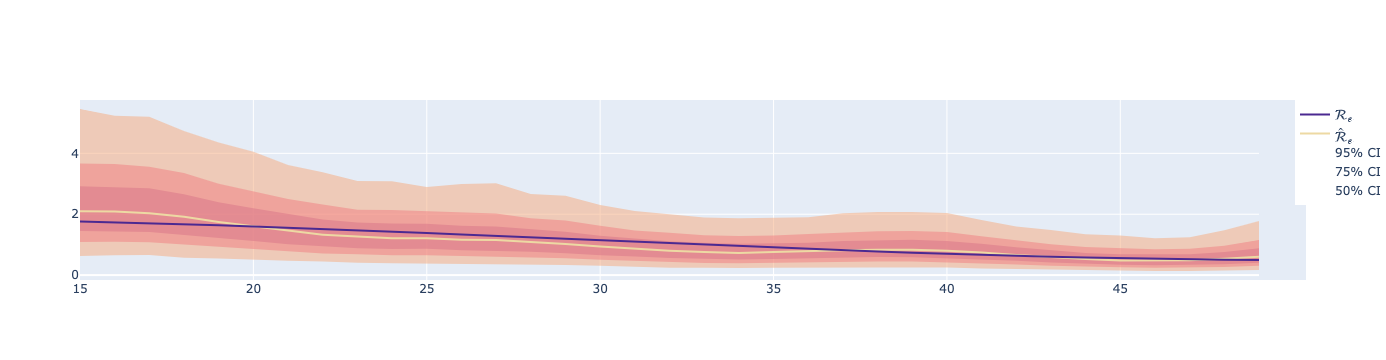

In [516]:
def plot_reproduction_number(xx, R_matrix, Rt_true=None):
    layout = go.Layout(colorway=px.colors.sequential.Agsunset)
    fig = go.Figure([
        *get_quantile_traces(
            xx,
            R_matrix.T,
            quantiles=[0.5, 0.75, 0.95],
            title="$\hat{\mathcal{R}}_e$")
    ], layout=layout)
    
    if Rt_true is not None:
        fig.add_trace(go.Scatter(x=xx, y=Rt_true, name=r"$\mathcal{R}_{e}$"))

    fig.show()

plot_reproduction_number(x_ind, R_eff, Rt_ts[t_1 - hyperparameters.window_size + hyperparameters.a_max:t_1])

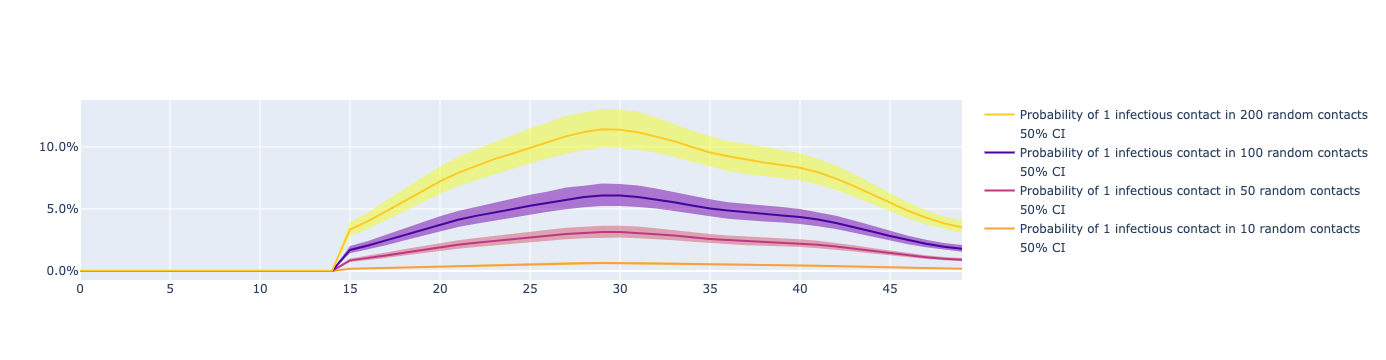

In [500]:
def plot_infected_contact_prob(xx, prevalence_matrix, pop_size, contact_counts=[10, 50, 100, 200]):
    prob_matrices = [
        st.hypergeom(M=pop_size, n=prevalence_matrix, N=N).pmf(1)
        for N in contact_counts]

    layout = go.Layout(yaxis=dict(tickformat=".1%"), colorway=px.colors.sequential.Plasma_r)
    fig = go.Figure(layout=layout)

    for prob_matrix, N in zip(prob_matrices, contact_counts):
        fig.add_traces(get_quantile_traces(
            xx,
            prob_matrix.T,
            title='Probability of 1 infectious contact in {} random contacts'.format(N),
            quantiles=[0.5]))

    fig.show()

plot_infected_contact_prob(np.arange(hyperparameters.window_size), prevalence_mat, prague_node.N)

# NA HOVNO

## TODO: solve this

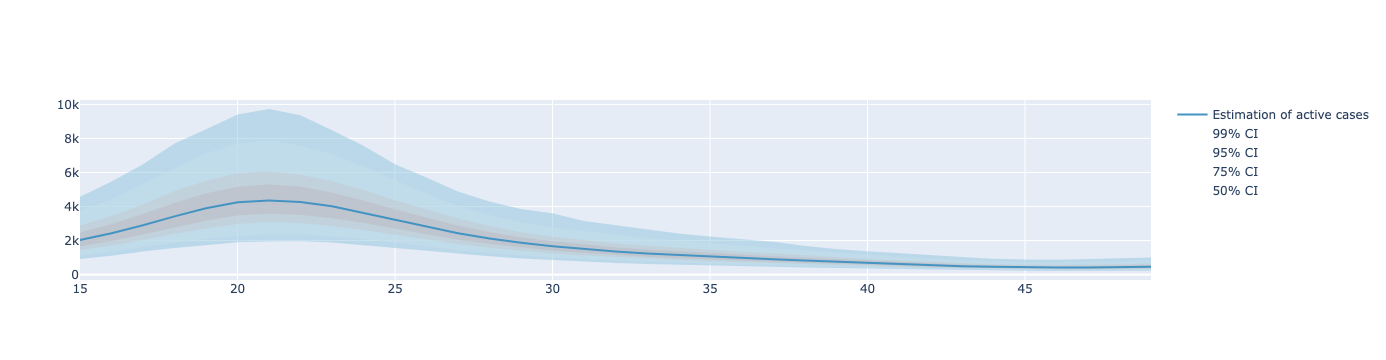

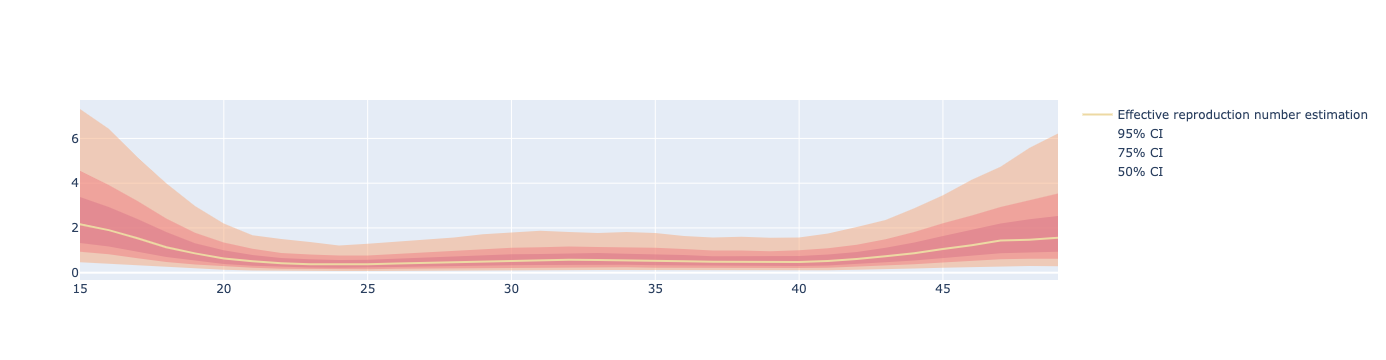

In [79]:
prevalence_mat = make_prevalence_matrix(incidence_mat, si_weights)
Rt = incidence_mat[:, len(si_weights):] / prevalence_mat[:, :]

xx_dates_epi = np.arange(len(si_weights), window_size)
plot_active_cases_estimation(xx_dates_epi, prevalence_mat)
plot_reproduction_number(xx_dates_epi, Rt)

----

Not developed yet

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 49 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


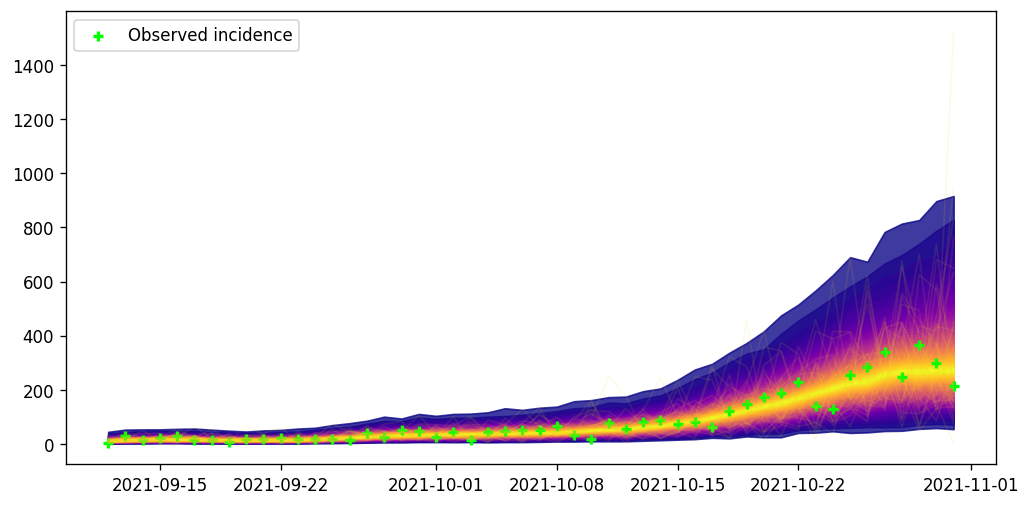

In [ ]:
class EpidemicEstimator:
    def __init__(self, nuts_code, serial_interval: SerialInterval, si_len, window_size):
        self.si_len = si_len
        self.si_weights = serial_interval.as_weights(si_len)
        self.window_size = window_size
        self.data = data_manager[nuts_code]

    def estimate(self, to_date: str):
        end_index = self.data.get_index_by_date(to_date)
        start_index = end_index - self.window_size
        xx_dates = self.data.dates[start_index:end_index]

        observed_incidence = self.data.obs_ΔC[start_index:end_index]
        model = build_model(observed_incidence)
        trace = sample_model(model)
        ppc = make_posterior_predictive(model, trace)
        incidence_mat = ppc["incidence"]
        plot_posterior(xx_dates, incidence_mat, observed_incidence)

        prevalence_mat = make_prevalence_matrix(incidence_mat, self.si_weights)
        Rt = incidence_mat[:, len(self.si_weights):] / prevalence_mat[:, :]

        xx_dates_epi = xx_dates[len(self.si_weights):]
        plot_active_cases_estimation(xx_dates_epi, prevalence_mat)
        plot_reproduction_number(xx_dates_epi, Rt)
        plot_infected_contact_prob(xx_dates_epi, prevalence_mat, self.data.N)

estimator = EpidemicEstimator(nuts_code=BRNO_CODE, serial_interval=nishiura_si, si_len=tau_m, window_size=window_size)
estimator.estimate("2021-11-1")